In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2 style='color:blue' align='center'>Data Augmentation To Address Overfitting In Flower Classification CNN</h2>

**In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc**

Credits: I used tensorflow offical tutorial: https://www.tensorflow.org/tutorials/images/classification as a reference and made bunch of changes to make it simpler

In below image, 4 new training samples are generated from original sample using different transformations

<img src="daisy2.JPG" />

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

<h3 style='color:purple'>Load flowers dataset</h3>

In [ ]:
# cache_dir indicates where to download data.
# untar true will unzip it
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation', untar=True)

228813984/228813984 [==============================] - 2s 0us/step


In [ ]:
data_dir

'/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos'

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos')

In [ ]:
# List of images with .jpg extension
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [ ]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

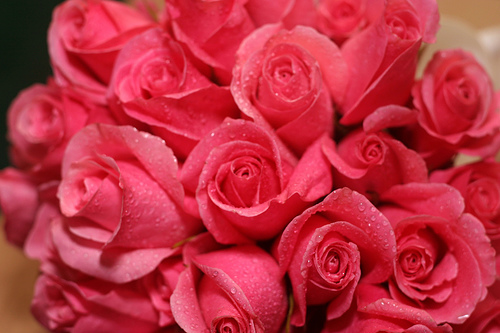

In [ ]:
PIL.Image.open(str(roses[1]))

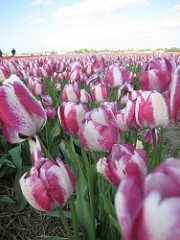

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [ ]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [ ]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [ ]:
flowers_images_dict['roses'][:5]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

In [ ]:
str(flowers_images_dict['roses'][0])

'/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data Augmentation/datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'

array([[[255, 254, 254],
        [248, 253, 252],
        [244, 250, 249],
        ...,
        [255, 249, 254],
        [255, 248, 254],
        [255, 248, 254]],

       [[127, 174, 225],
        [134, 191, 236],
        [127, 179, 219],
        ...,
        [152, 197, 234],
        [144, 198, 233],
        [144, 198, 233]],

       [[174, 202, 232],
        [163, 200, 228],
        [167, 204, 232],
        ...,
        [170, 207, 235],
        [173, 207, 237],
        [173, 207, 237]],

       ...,

       [[252, 245, 252],
        [253, 246, 253],
        [253, 246, 253],
        ...,
        [253, 249, 255],
        [249, 245, 251],
        [249, 245, 251]],

       [[254, 247, 254],
        [254, 247, 254],
        [253, 246, 253],
        ...,
        [251, 243, 253],
        [252, 248, 254],
        [252, 248, 254]],

       [[249, 246, 255],
        [248, 245, 254],
        [248, 245, 254],
        ...,
        [254, 245, 255],
        [250, 243, 255],
        [250, 243, 255]]], dtype=uint8)
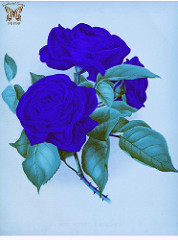

In [ ]:
# cv2 read the image and converted it to numpy array
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img

In [ ]:
img.shape

(240, 178, 3)

In [ ]:
# Convert all images into the same Dimension
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [ ]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [ ]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [ ]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

<h3 style='color:purple'>Build convolutional neural network and train it</h3>

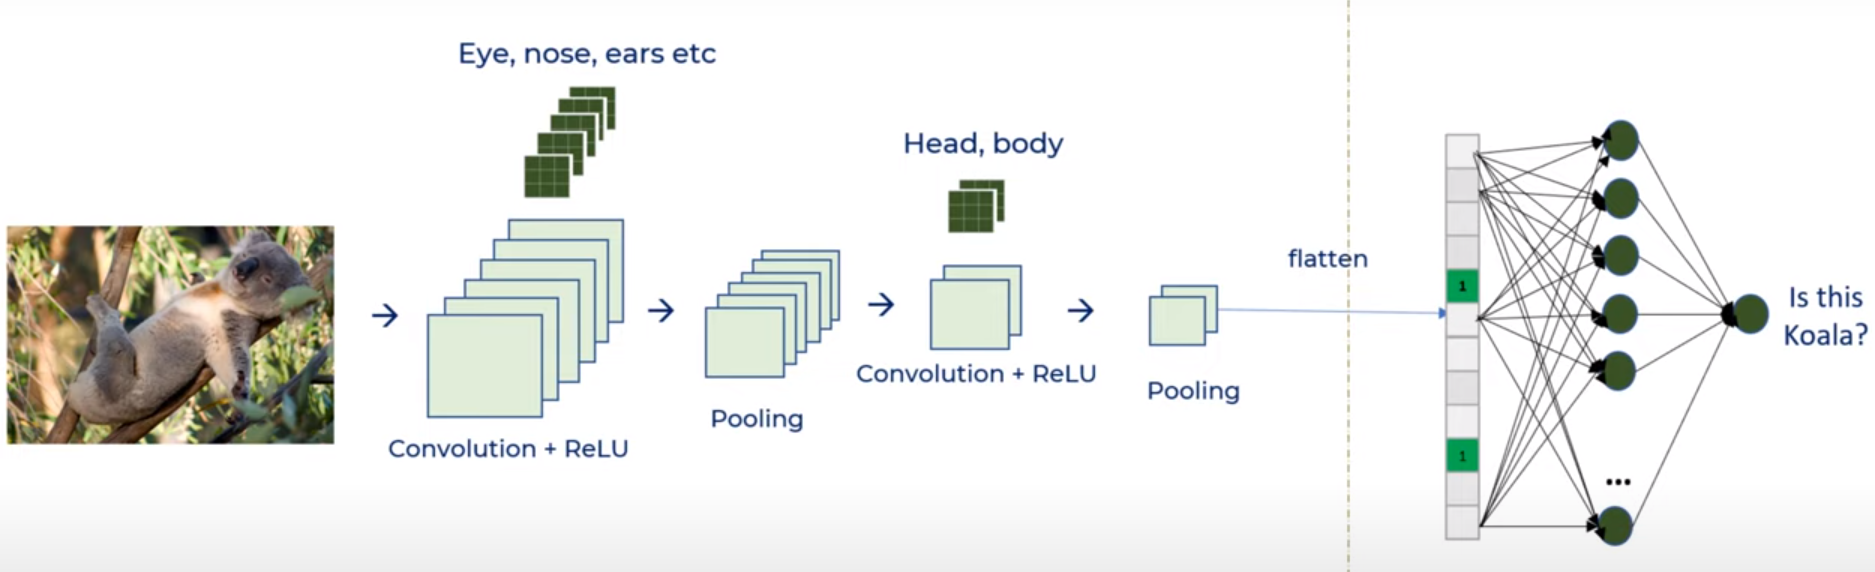

In [ ]:
num_classes = 5 # 5 types of flowers in the dataset

model = Sequential([
  # 16 = 16 filters, 3 = 3*3 filter size
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # Linear will be used since no activation was specified
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
 2/86 [..............................] - ETA: 27s - loss: 2.9819 - accuracy: 0.2188WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0060s vs `on_train_batch_end` time: 0.3163s). Check your callbacks.


86/86 [==============================] - 4s 46ms/step - loss: 1.3792 - accuracy: 0.4299
Epoch 2/30
86/86 [==============================] - 1s 16ms/step - loss: 1.0410 - accuracy: 0.6036 0s - loss: 1.0534 - 
Epoch 3/30
86/86 [==============================] - 2s 18ms/step - loss: 0.8758 - accuracy: 0.6711
Epoch 4/30
86/86 [==============================] - 1s 17ms/step - loss: 0.7006 - accuracy: 0.7435
Epoch 5/30
86/86 [==============================] - 1s 15ms/step - loss: 0.4797 - accuracy: 0.8176
Epoch 6/30
86/86 [==============================] - 1s 15ms/step - loss: 0.2849 - accuracy: 0.9077
Epoch 7/30
86/86 [==============================] - 1s 11ms/step - loss: 0.1473 - accuracy: 0.9575
Epoch 8/30
86/86 [==============================] - 1s 10ms/step - loss: 0.1164 - accuracy: 0.9655
Epoch 9/30
86/86 [==============================] - 1s 10ms/step - loss: 0.0770 - accuracy: 0.9782
Epoch 10/30
86/86 [==============================] - 1s 10ms/step - loss: 0.0439 - accuracy: 0.9866

In [ ]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 0s 5ms/step - loss: 2.4165 - accuracy: 0.6699


[2.4165186882019043, 0.6699346303939819]

**Here we see that while train accuracy is very high (99%), the test accuracy is significantly low (66.99%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting**

In [ ]:
predictions = model.predict(X_test_scaled)
predictions

array([[  5.5538044 ,  28.357603  ,  -2.64333   , -17.732698  ,
         -8.868293  ],
       [  7.971043  ,   7.614807  , -11.15702   ,  -9.508243  ,
          2.866003  ],
       [  0.12697598,   3.7088952 ,  13.012845  , -17.065691  ,
         -1.0256854 ],
       ...,
       [ -1.2454829 ,  -6.018974  ,  -9.245011  ,   6.1912336 ,
          3.9217234 ],
       [ -0.2303026 ,  -0.22910628,  -7.751635  ,   6.4317822 ,
          4.1837516 ],
       [  0.5132807 , -20.254309  ,  -1.2567687 ,   7.799835  ,
          3.5779328 ]], dtype=float32)

In [ ]:
score = tf.nn.softmax(predictions[0])

In [ ]:
np.argmax(score)

1

In [ ]:
y_test[0]

1

<h3 style='color:purple'>Improve Test Accuracy Using Data Augmentation</h3>

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(180,
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

**Original Image**

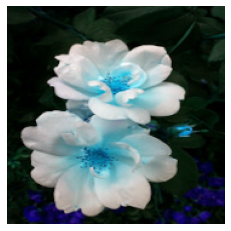

In [ ]:
plt.axis('off')
plt.imshow(X[0])

**Newly generated training sample using data augmentation**

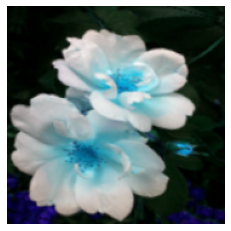

In [ ]:
plt.axis('off')
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

<h3 style='color:purple'>Train the model using data augmentation and a drop out layer</h3>

In [ ]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 [==============================] - 1s 17ms/step - loss: 1.4347 - accuracy: 0.3844
Epoch 2/30
86/86 [==============================] - 1s 16ms/step - loss: 1.0742 - accuracy: 0.5789
Epoch 3/30
86/86 [==============================] - 1s 15ms/step - loss: 0.9900 - accuracy: 0.6130
Epoch 4/30
86/86 [==============================] - 1s 13ms/step - loss: 0.9247 - accuracy: 0.6421
Epoch 5/30
86/86 [==============================] - 1s 14ms/step - loss: 0.8485 - accuracy: 0.6722
Epoch 6/30
86/86 [==============================] - 1s 16ms/step - loss: 0.8226 - accuracy: 0.6893
Epoch 7/30
86/86 [==============================] - 1s 14ms/step - loss: 0.7964 - accuracy: 0.6944
Epoch 8/30
86/86 [==============================] - 1s 15ms/step - loss: 0.7662 - accuracy: 0.7140
Epoch 9/30
86/86 [==============================] - 1s 16ms/step - loss: 0.7292 - accuracy: 0.7249
Epoch 10/30
86/86 [==============================] - 2s 18ms/step - loss: 0.6941 - accuracy: 0.7362
Epoch 11/

In [ ]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 0s 5ms/step - loss: 0.8419 - accuracy: 0.7375


[0.8418797850608826, 0.7374727725982666]

**You can see that by using data augmentation and drop out layer the accuracy of test set predictions is increased to 73.74%**